In [1]:
import os
import sys
code_dir = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code'
code_dir_2 = '/home/ben/masters-project/ben-rhodes-masters-project/proposal/code'
code_dir_3 = '/afs/inf.ed.ac.uk/user/s17/s1771906/masters-project/ben-rhodes-masters-project/proposal/code/neural_network'
code_dir_4 = '/home/ben/masters-project/ben-rhodes-masters-project/proposal/code/neural_network'
code_dirs = [code_dir, code_dir_2, code_dir_3, code_dir_4]
for code_dir in code_dirs:
    if code_dir not in sys.path:
        sys.path.append(code_dir)

In [2]:
import numpy as np
import pickle

# my code
from distribution import MissingDataProductOfTruncNormsPosterior, MissingDataProductOfTruncNormNoise, LearnedVariationalNoise
from fully_observed_models import MixtureOfTwoGaussians
from latent_variable_model import MissingDataUnnormalisedTruncNorm
from nce_optimiser import NCEOptimiser
from plot import *
from utils import *
from vnce_optimiser import VemOptimiser, SgdEmStep, MonteCarloVnceLoss

from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.optimize import newton_krylov
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=1)
rc('font', size=10)
rc('legend', fontsize=10)

In [3]:
np.diag(np.diag(np.arange(9).reshape(3,3)))

array([[0, 0, 0],
       [0, 4, 0],
       [0, 0, 8]])

In [4]:
# load_path = '/home/ben/masters-project/ben-rhodes-masters-project/experimental-results/trunc-norm/learning-a-noise/test/'
load_path = '/home/ben/masters-project/ben-rhodes-masters-project/experimental-results/trunc-norm/2d/frac=0/'
# load_path = '/disk/scratch/ben-rhodes-masters-project/experimental-results/trunc_norm/test/d=2-frac=0.1/'

In [5]:
data_dist = pickle.load(open(os.path.join(load_path, 'data_dist.p'), 'rb'))

In [6]:
vnce_model = pickle.load(open(os.path.join(load_path, 'vnce_model.p'), 'rb'))

In [7]:
nce_model = pickle.load(open(os.path.join(load_path, 'nce_model.p'), 'rb'))
# nce_model_2 = pickle.load(open(os.path.join(load_path, 'nce_model_2.p'), 'rb'))
nce_model_2 = pickle.load(open(os.path.join(load_path, 'nce_filled_in_mean_model.p'), 'rb'))

In [8]:
var_dist = pickle.load(open(os.path.join(load_path, 'var_dist.p'), 'rb'))

In [9]:
noise = pickle.load(open(os.path.join(load_path, 'noise.p'), 'rb'))

In [10]:
globals().update(np.load(os.path.join(load_path, 'data.npz')))
globals().update(np.load(os.path.join(load_path, 'theta0_and_theta_true.npz')))

In [11]:
# contour plot of q(z|x)p_y(x) next to cplot of model 
# do this for two cases: z is first dimension, and z is second dimension
def get_visible_and_latents(U, latent_dim=1):
    visible_dim = int(~latent_dim)
    x = np.zeros_like(U)
    z = np.zeros((1, ) + U.shape)
    
    x[:, visible_dim] = U[:, visible_dim]
    z[0, :, latent_dim] = U[:, latent_dim]
    return x, z

def joint_noise(U):
    x, z = get_visible_and_latents(U)
    return var_dist(z, x) * noise(x)

def joint_noise_rev(U):
    x, z = get_visible_and_latents(U, latent_dim=0)
    return var_dist(z, x) * noise(x)

def eval_vnce_model(U):
    x, z = get_visible_and_latents(U)
    return vnce_model(x, z)

def eval_data_dist(U):
    x, z = get_visible_and_latents(U)
    return data_dist(x, z)
    
def eval_nce_model(U):
    return nce_model(U)

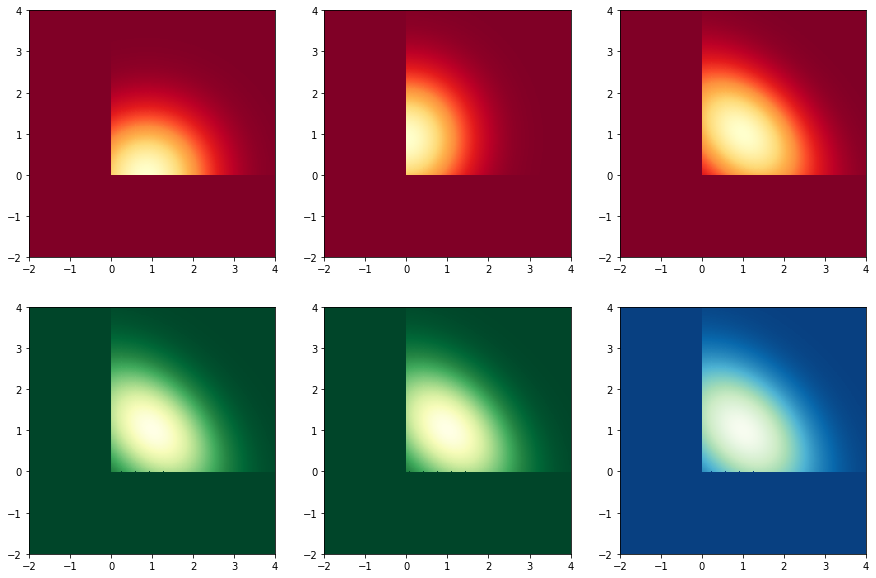

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
x_low, x_high, y_low, y_high= -2, 4, -2, 4
plot_2d_density(axs[0], joint_noise, plt.cm.YlOrRd_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[1], joint_noise_rev, plt.cm.YlOrRd_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[2], eval_vnce_model, plt.cm.YlOrRd_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[3], nce_model, plt.cm.YlGn_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[4], nce_model_2, plt.cm.YlGn_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)
plot_2d_density(axs[5], eval_data_dist, plt.cm.GnBu_r, low_x_lim=x_low, up_x_lim=x_high, low_y_lim=y_low, up_y_lim=y_high)

In [13]:
vnce_model.theta

array([ 1.48078674,  1.00318388,  1.0034342 ,  0.00498881,  0.42103117,
        0.04924118])

In [14]:
nce_model.theta

array([ 1.47876031,  1.00273062,  1.0212343 ,  0.00463769,  0.42094528,
        0.02664588])

In [15]:
# old -  0.76872111
# noise.alpha[-2] = 0.7687211

In [16]:
new_noise = LearnedVariationalNoise(var_dist)

In [17]:
new_noise_sample = new_noise.sample(X_train, 100)

In [18]:
np.mean(new_noise(new_noise_sample, log=True))

-1.4541579197475756

In [19]:
var_dist.sample(1, np.zeros((10, 2)), np.ones((10, 2)))

array([[[ 1.03608207,  0.15838934],
        [ 2.13217089,  0.35844157],
        [ 1.48831517,  0.56543157],
        [ 1.17142479,  0.16874639],
        [ 0.24894812,  1.09353158],
        [ 0.38146395,  0.8588074 ],
        [ 1.07822309,  1.14286824],
        [ 1.72729081,  0.3197286 ],
        [ 1.46262061,  0.41129778],
        [ 0.17309675,  0.1631948 ]]])